In [35]:
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
from scipy.signal import stft

In [34]:
gen_edm = pd.read_csv('final/edm.csv')
gen_pop = pd.read_csv('final/pop.csv')
gen_rnb = pd.read_csv('final/rnb.csv')
gen_rock = pd.read_csv('final/rock.csv')
gen_rap = pd.read_csv('final/rap.csv')

In [3]:
y_edm, sr_edm = librosa.load(gen_edm['audio_path'][0])
y_rnb, sr_rnb = librosa.load(gen_rnb['audio_path'][0])
y_pop, sr_pop = librosa.load(gen_pop['audio_path'][0])
y_rock, sr_rock = librosa.load(gen_rock['audio_path'][0])
y_rap, sr_rap = librosa.load(gen_rap['audio_path'][0])

[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?


### Display Pre-emphasis

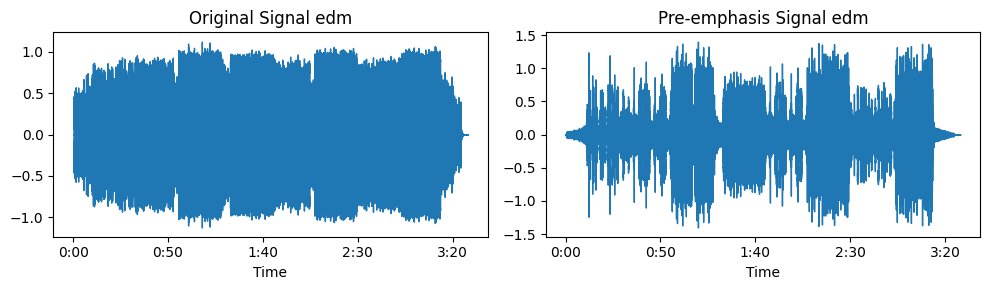

In [4]:
pre_emphasis = 0.97
def emphasis(signal):
  return np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
  

emphasis_edm = emphasis(y_edm)
emphasis_pop = emphasis(y_pop)
emphasis_rock = emphasis(y_rock)
emphasis_rnb = emphasis(y_rnb)
emphasis_rap = emphasis(y_rap)

before_emphasis = y_edm
emphasis_sr = sr_edm

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
librosa.display.waveshow(before_emphasis, sr=emphasis_sr)
plt.title(f'Original Signal edm')

plt.subplot(1, 2, 2)
librosa.display.waveshow(emphasis_edm, sr=emphasis_sr)
plt.title(f'Pre-emphasis Signal edm')

plt.tight_layout()


### Display framing & windowing

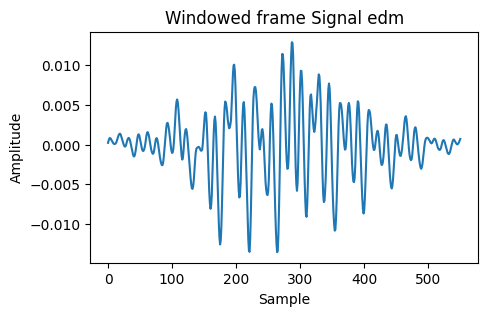

In [5]:
frame_size = 0.025
frame_stride = 0.01

def framing(emphasized_signal, sr):
  frame_length, frame_step = frame_size * sr, frame_stride * sr  # Convert from seconds to samples
  signal_length = len(emphasized_signal)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  return pad_signal[indices.astype(np.int32, copy=False)]

def windowing(framing_signal, windowing_sr):
  return framing_signal * np.hamming(frame_size * windowing_sr)

framed_edm = framing(emphasis_edm, sr_edm)
framed_pop = framing(emphasis_pop, sr_pop)
framed_rnb = framing(emphasis_rnb, sr_rnb)
framed_rock = framing(emphasis_rock, sr_rock)
framed_rap = framing(emphasis_rap, sr_rap)

windowed_edm = windowing(framed_edm, sr_edm)
windowed_pop = windowing(framed_pop, sr_pop)
windowed_rnb = windowing(framed_rnb, sr_rnb)
windowed_rock = windowing(framed_rock, sr_rock)
windowed_rap = windowing(framed_rap, sr_rap)

plot_framing_windowing_signal, plot_framing_windowing_name = windowed_edm[100], "edm"
plt.figure(figsize=(5, 3))
plt.plot(plot_framing_windowing_signal)
plt.title(f'Windowed frame Signal {plot_framing_windowing_name}')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


### Display FFT

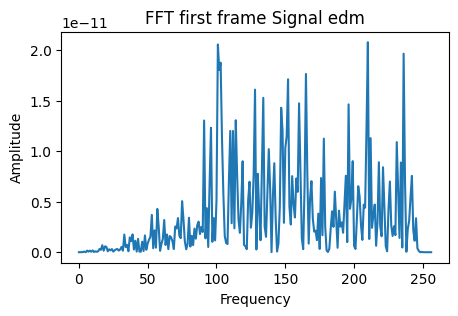

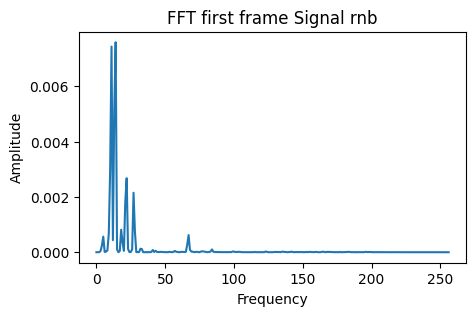

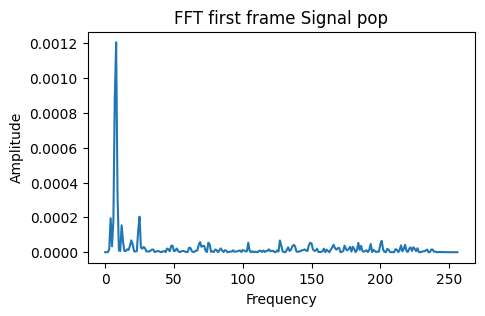

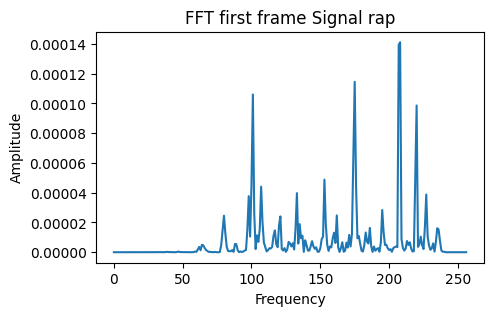

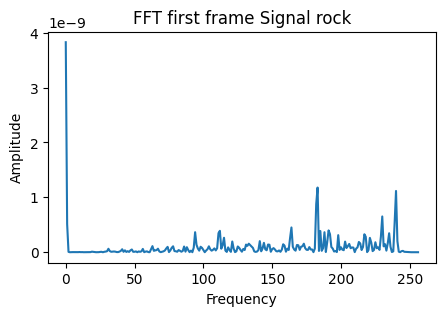

In [6]:
NFFT = 512
def fft(framed_windowed_signal):
  mag_frames = np.absolute(np.fft.rfft(framed_windowed_signal, NFFT))  # Magnitude of the FFT
  pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
  return pow_frames

fft_edm = fft(windowed_edm)
fft_pop = fft(windowed_pop)
fft_rnb = fft(windowed_rnb)
fft_rock = fft(windowed_rock)
fft_rap = fft(windowed_rap)

def display_fft(signal, name):
  plt.figure(figsize=(5, 3))
  plt.plot(signal)
  plt.title(f'FFT first frame Signal {name}')
  plt.xlabel('Frequency')
  plt.ylabel('Amplitude')
  plt.show()
 
display_fft(fft_edm[10], "edm")
display_fft(fft_rnb[10], "rnb")
display_fft(fft_pop[10], "pop")
display_fft(fft_rap[10], "rap")
display_fft(fft_rock[10], "rock")

### Display mel

In [7]:
nfilt = 20

def melbanks(pow_frames, sr):
  low_freq_mel = 0
  high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
  hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
  bin = np.floor((NFFT + 1) * hz_points / sr)

  fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
  for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
      fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
      fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
  filter_banks = np.dot(pow_frames, fbank.T)
  filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
  return (20 * np.log10(filter_banks)), fbank

mel_edm, filter_banks_edm = melbanks(fft_edm, sr_edm)
mel_pop, filter_banks_pop = melbanks(fft_pop, sr_pop)
mel_rnb, filter_banks_rnb = melbanks(fft_rnb, sr_rnb)
mel_rock, filter_banks_rock = melbanks(fft_rock, sr_rock)
mel_rap, filter_banks_rap = melbanks(fft_edm, sr_rap)

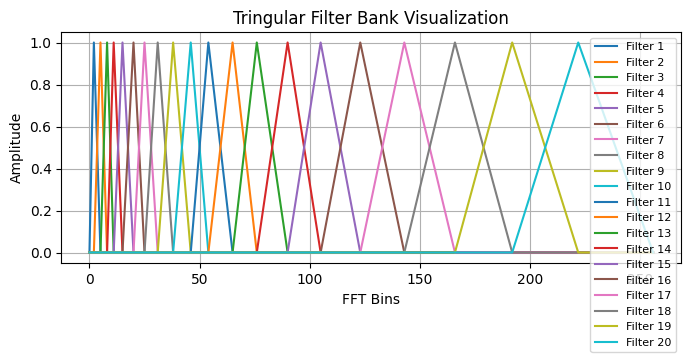

In [8]:
plt.figure(figsize=(8, 3))
for i in range(nfilt):
  plt.plot(filter_banks_edm[i], label=f'Filter {i+1}')

plt.title(f'Tringular Filter Bank Visualization')
plt.xlabel('FFT Bins')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend(loc='upper right', fontsize=8)
plt.show()

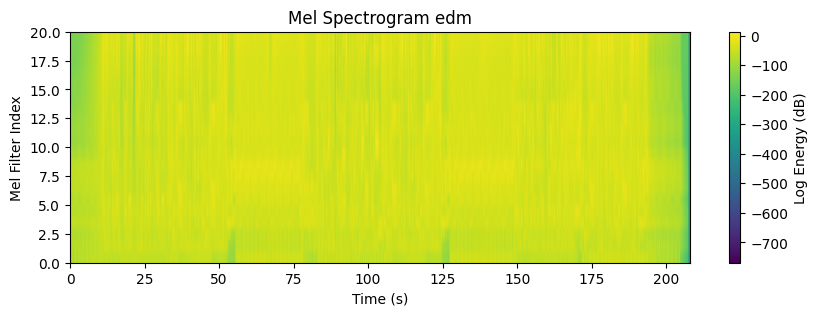

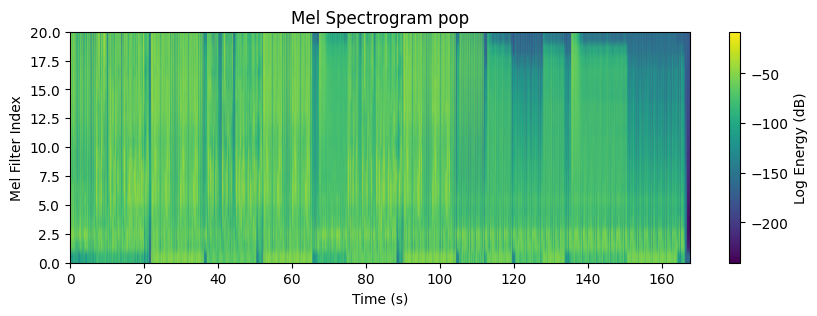

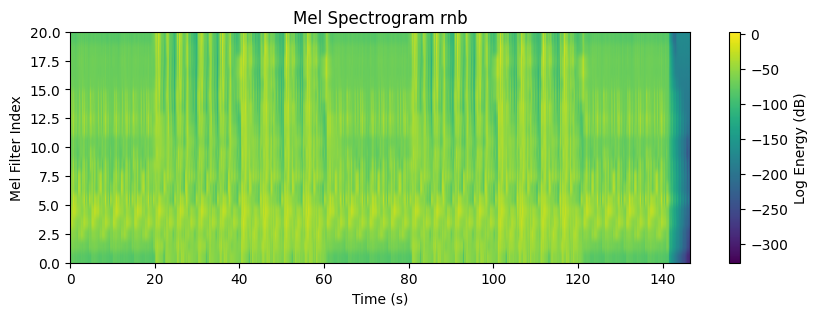

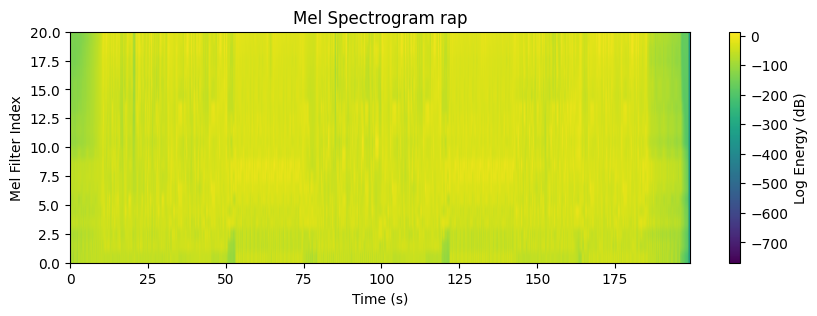

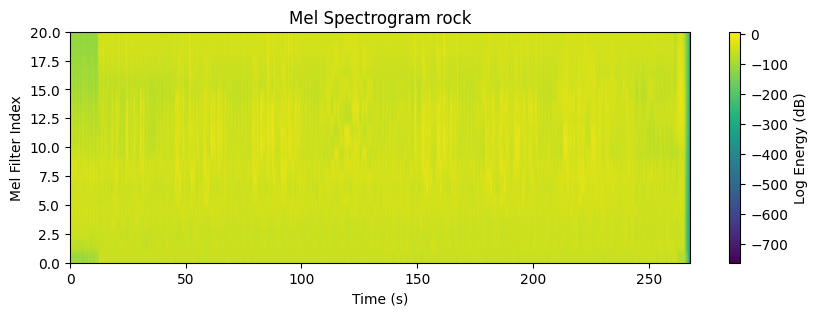

In [46]:
def spec_show(signal, sr, mel, name):
  plt.figure(figsize=(10, 3))
  duration = librosa.get_duration(y=signal, sr=sr)
  plt.imshow(mel.T, aspect='auto', origin='lower', cmap='viridis',
             extent=[0, duration, 0, nfilt])
  plt.title(f"Mel Spectrogram {name}")
  plt.ylabel("Mel Filter Index")
  plt.xlabel("Time (s)")
  plt.colorbar(label="Log Energy (dB)")
  plt.show()
  
spec_show(y_edm, sr_edm, mel_edm, "edm")
spec_show(y_pop, sr_pop, mel_pop, "pop")
spec_show(y_rnb, sr_rnb, mel_rnb, "rnb")
spec_show(y_rap, sr_rap, mel_rap, "rap")
spec_show(y_rock, sr_rock, mel_rock, "rock")
